<a href="https://colab.research.google.com/github/padfoot194/Speech-Emotion-Recognition_EEE-312_Project/blob/main/Codes/Bangla_Dataset_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import wave
import struct
from scipy.stats import skew, kurtosis
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import math

ZIP Extraction

In [ ]:
def extract_zip(zip_path, extract_to="Emotion_Dataset"):

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f" ZIP file not found at {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        total_files_in_zip = len(zip_ref.infolist())
        zip_ref.extractall(extract_to)
        print(f" ZIP extracted to {extract_to}")
        extracted_files = sum(len(files) for _, _, files in os.walk(extract_to))
        if extracted_files == total_files_in_zip:
            print(f" Successfully read all {total_files_in_zip} files from the ZIP.")
        else:
            print(f" Warning: Expected {total_files_in_zip} files, but found {extracted_files} extracted files.")
    return extract_to

Dataset Exploration

In [ ]:
def explore_dataset(dataset_path):

    dataset_info = {}
    print(" Dataset Structure:")
    for item in os.listdir(dataset_path):
        item_path = Path(dataset_path) / item
        if item_path.is_dir():
            wav_files = list(item_path.glob("*.wav"))
            dataset_info[item.lower()] = len(wav_files)
            print(f" {item}: {len(wav_files)} WAV files")
            if wav_files:
                print(f" Examples: {[f.name for f in wav_files[:3]]}")
    return dataset_info

WAV File Reading

In [ ]:
def read_wav_file(file_path):

    try:
        with wave.open(file_path, 'rb') as wav_file:
            num_channels = wav_file.getnchannels()
            num_frames = wav_file.getnframes()
            sample_rate = wav_file.getframerate()
            audio_data = wav_file.readframes(num_frames)
            audio_signal = struct.unpack(f"{num_frames * num_channels}h", audio_data)
            audio_signal = np.array(audio_signal, dtype=np.float32)
            if num_channels > 1:
                audio_signal = audio_signal[::num_channels]  # Use one channel
            return audio_signal, sample_rate
    except Exception as e:
        print(f" Error reading {file_path}: {e}")
        return None, None

Audio Files Loading

In [ ]:
def load_audio_files(dataset_path):

    audio_data = []
    for emotion_folder in os.listdir(dataset_path):
        folder_path = Path(dataset_path) / emotion_folder
        if folder_path.is_dir():
            print(f"\n Processing {emotion_folder} folder...")
            wav_files = list(folder_path.glob("*.wav"))
            for i, wav_file in enumerate(wav_files):
                signal, sample_rate = read_wav_file(str(wav_file))
                if signal is None:
                    continue
                file_info = {
                    'file_path': str(wav_file),
                    'file_name': wav_file.name,
                    'emotion': emotion_folder.lower(),
                    'signal': signal,
                    'sample_rate': sample_rate,
                    'duration': len(signal) / sample_rate,
                    'signal_length': len(signal)
                }
                audio_data.append(file_info)
                if (i + 1) % 50 == 0 or i == len(wav_files) - 1:
                    print(f" Processed {i + 1}/{len(wav_files)} files")
    return audio_data

Audio Preprocessing

In [ ]:
def preprocess_audio(signal):

    if np.max(np.abs(signal)) > 0:
        normalized_signal = signal / np.max(np.abs(signal))
    else:
        normalized_signal = signal
    return normalized_signal

def create_frames(signal, frame_size=1024, hop_length=512):

    frames = []
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        frames.append(frame)
    return np.array(frames)


Feature Extraction Utilities

In [ ]:
def hz_to_mel(hz):

    return 2595 * np.log10(1 + hz / 700)

def mel_to_hz(mel):

    return 700 * (10**(mel / 2595) - 1)

def create_mel_filter_bank(sample_rate, n_fft, n_mels=20, fmin=0, fmax=None):

    if fmax is None:
        fmax = sample_rate / 2
    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((n_fft + 1) * hz_points / sample_rate).astype(int)
    filter_bank = np.zeros((n_mels, n_fft // 2 + 1))
    for i in range(1, n_mels + 1):
        left, center, right = bin_points[i - 1:i + 2]
        filter_bank[i - 1, left:center] = np.linspace(0, 1, center - left)
        filter_bank[i - 1, center:right] = np.linspace(1, 0, right - center)
    return filter_bank, hz_points

def manual_dct(x):

    N = len(x)
    result = np.zeros(N)
    for k in range(N):
        result[k] = np.sum([x[n] * np.cos(np.pi * k * (2 * n + 1) / (2 * N)) for n in range(N)])
        result[0] *= 1 / np.sqrt(N)
        result[1:] *= np.sqrt(2 / N)
    return result

Feature Extraction

In [ ]:
def extract_all_features(signal, sample_rate, frame_size=1024, hop_length=512):

    normalized_signal = preprocess_audio(signal)
    frames = create_frames(normalized_signal, frame_size, hop_length)
    features = {}

    # Time-domain features
    frame_energies = [np.sqrt(np.mean(frame**2)) for frame in frames]
    frame_zcr = [np.sum(np.abs(np.diff(np.sign(frame)))) / (2 * len(frame)) for frame in frames]
    features['energy_mean'] = np.mean(frame_energies)
    features['energy_std'] = np.std(frame_energies)
    features['zcr_mean'] = np.mean(frame_zcr)
    features['zcr_std'] = np.std(frame_zcr)

    # Spectral features
    spectral_centroids, spectral_rolloffs, spectral_bandwidths = [], [], []
    for frame in frames:
        windowed_frame = frame * np.hanning(len(frame))
        fft = np.fft.fft(windowed_frame)
        magnitude = np.abs(fft[:len(fft)//2])
        freqs = np.fft.fftfreq(len(frame), 1/sample_rate)[:len(frame)//2]
        if np.sum(magnitude) > 0:
            centroid = np.sum(freqs * magnitude) / np.sum(magnitude)
            spectral_centroids.append(centroid)
            cumulative_energy = np.cumsum(magnitude)
            rolloff_index = np.where(cumulative_energy >= 0.95 * cumulative_energy[-1])[0]
            if len(rolloff_index) > 0:
                spectral_rolloffs.append(freqs[rolloff_index[0]])
            bandwidth = np.sqrt(np.sum(((freqs - centroid)**2) * magnitude) / np.sum(magnitude))
            spectral_bandwidths.append(bandwidth)
    features['spectral_centroid_mean'] = np.mean(spectral_centroids) if spectral_centroids else 0.0
    features['spectral_centroid_std'] = np.std(spectral_centroids) if spectral_centroids else 0.0
    features['spectral_centroid_skew'] = skew(spectral_centroids) if spectral_centroids else 0.0
    features['spectral_centroid_kurtosis'] = kurtosis(spectral_centroids) if spectral_centroids else 0.0
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloffs) if spectral_rolloffs else 0.0
    features['spectral_rolloff_std'] = np.std(spectral_rolloffs) if spectral_rolloffs else 0.0
    features['spectral_rolloff_skew'] = skew(spectral_rolloffs) if spectral_rolloffs else 0.0
    features['spectral_rolloff_kurtosis'] = kurtosis(spectral_rolloffs) if spectral_rolloffs else 0.0
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidths) if spectral_bandwidths else 0.0
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidths) if spectral_bandwidths else 0.0

    # MFCC features
    mel_filters, _ = create_mel_filter_bank(sample_rate, frame_size, n_mels=20)
    all_mfccs = []
    for frame in frames:
        windowed_frame = frame * np.hamming(len(frame))
        fft = np.fft.fft(windowed_frame)
        power_spectrum = np.abs(fft[:len(fft)//2 + 1]) ** 2
        mel_energies = np.dot(mel_filters, power_spectrum)
        mel_energies = np.where(mel_energies == 0, np.finfo(float).eps, mel_energies)
        log_mel_energies = np.log(mel_energies)
        mfcc = manual_dct(log_mel_energies)
        all_mfccs.append(mfcc[:13])
    all_mfccs = np.array(all_mfccs)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(all_mfccs[:, i]) if all_mfccs.size else 0.0
        features[f'mfcc_{i}_std'] = np.std(all_mfccs[:, i]) if all_mfccs.size else 0.0
        features[f'mfcc_{i}_skew'] = skew(all_mfccs[:, i]) if all_mfccs.size else 0.0
        features[f'mfcc_{i}_kurtosis'] = kurtosis(all_mfccs[:, i]) if all_mfccs.size else 0.0

    # Mel-spectrogram features
    frame_len = int(round(0.025 * sample_rate))
    hop_len = int(round(0.010 * sample_rate))
    NFFT = 512
    mel_filters = create_mel_filter_bank(sample_rate, NFFT, n_mels=40)[0]
    frames = [normalized_signal[i:i+frame_len] for i in range(0, len(normalized_signal)-frame_len, hop_len)]
    mel_energies = []
    for frame in frames:
        windowed = frame * np.hamming(frame_len)
        spectrum = np.abs(np.fft.fft(windowed, NFFT)[:NFFT//2 + 1])
        mel_energy = np.dot(mel_filters, spectrum)
        mel_energy = np.log10(mel_energy + np.finfo(float).eps)
        mel_energies.append(mel_energy)
    mel_energies = np.array(mel_energies)
    features['mel_spectrogram_mean'] = np.mean(mel_energies) if mel_energies.size else 0.0
    features['mel_spectrogram_std'] = np.std(mel_energies) if mel_energies.size else 0.0
    features['mel_spectrogram_skew'] = skew(mel_energies.flatten()) if mel_energies.size else 0.0
    features['mel_spectrogram_kurtosis'] = kurtosis(mel_energies.flatten()) if mel_energies.size else 0.0

    # Chromagram features
    frame_len = 2048
    hop_len = 512
    chroma_bins = 12
    chroma_all = []
    for start in range(0, len(normalized_signal) - frame_len, hop_len):
        frame = normalized_signal[start:start + frame_len]
        fft = np.fft.fft(frame)
        magnitude = np.abs(fft[:len(fft)//2])
        freq_bins = np.fft.fftfreq(len(frame), 1 / sample_rate)[:len(frame)//2]
        chroma_vector = np.zeros(chroma_bins)
        for j in range(len(magnitude)):
            freq = freq_bins[j]
            if freq < 1: continue
            chroma_bin = int(round(12 * np.log2(freq / 440.0) + 69)) % 12
            chroma_vector[chroma_bin] += magnitude[j]
        chroma_all.append(chroma_vector)
    chroma_all = np.array(chroma_all)
    for i in range(chroma_bins):
        features[f'chroma_{i}_mean'] = np.mean(chroma_all[:, i]) if chroma_all.size else 0.0
        features[f'chroma_{i}_skew'] = skew(chroma_all[:, i]) if chroma_all.size else 0.0
        features[f'chroma_{i}_kurtosis'] = kurtosis(chroma_all[:, i]) if chroma_all.size else 0.0

    # Teager Energy Operator (TEO)
    features['teo_mean'] = np.mean(normalized_signal[1:-1]**2 - normalized_signal[:-2]*normalized_signal[2:]) if len(normalized_signal) > 2 else 0.0

    return features

Feature Visualization

In [ ]:
def visualize_features(frames, sample_rate, frame_index=50):

    frame = frames[frame_index]
    windowed_frame = frame * np.hamming(len(frame))
    fft = np.fft.fft(windowed_frame)
    magnitude = np.abs(fft[:len(fft)//2])
    freqs = np.fft.fftfreq(len(frame), 1/sample_rate)[:len(frame)//2]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(frame)
    plt.title(f'Frame {frame_index}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.subplot(1, 3, 2)
    plt.plot(windowed_frame)
    plt.title('Windowed Frame')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.subplot(1, 3, 3)
    plt.plot(freqs, magnitude)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 8000)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def visualize_mfcc_process(frames, sample_rate=48000):

    frame = frames[50]
    frame_size = len(frame)
    mel_filters, mel_freqs = create_mel_filter_bank(sample_rate, frame_size, 13)
    windowed_frame = frame * np.hanning(len(frame))
    fft = np.fft.fft(windowed_frame)
    power_spectrum = np.abs(fft[:len(fft)//2 + 1]) ** 2
    freqs = np.fft.fftfreq(frame_size, 1/sample_rate)[:len(fft)//2 + 1]
    mel_energies = np.dot(mel_filters, power_spectrum)
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)
    mfcc = manual_dct(log_mel_energies)
    plt.figure(figsize=(15, 12))
    plt.subplot(3, 2, 1)
    plt.plot(frame)
    plt.title('1. Original Frame')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.subplot(3, 2, 2)
    plt.plot(freqs, power_spectrum)
    plt.title('2. Power Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.xlim(0, 8000)
    plt.grid(True)
    plt.subplot(3, 2, 3)
    for i in range(min(13, mel_filters.shape[0])):
        plt.plot(freqs, mel_filters[i])
    plt.title('3. Mel Filter Bank')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Filter Response')
    plt.xlim(0, 8000)
    plt.grid(True)
    plt.subplot(3, 2, 4)
    plt.bar(range(len(mel_energies)), mel_energies)
    plt.title('4. Mel Energies')
    plt.xlabel('Mel Filter')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.subplot(3, 2, 5)
    plt.bar(range(len(log_mel_energies)), log_mel_energies)
    plt.title('5. Log Mel Energies')
    plt.xlabel('Mel Filter')
    plt.ylabel('Log Energy')
    plt.grid(True)
    plt.subplot(3, 2, 6)
    plt.bar(range(len(mfcc)), mfcc)
    plt.title('6. MFCC Coefficients')
    plt.xlabel('MFCC Index')
    plt.ylabel('MFCC Value')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return mfcc

Data Preparation

In [ ]:
def create_label_encoder(labels):

    unique_labels = sorted(list(set(labels)))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    return label_to_index, index_to_label

def manual_train_test_split(X, y, test_size=0.2, random_state=42):

    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_point = int(len(X) * (1 - test_size))
    train_indices, test_indices = indices[:split_point], indices[split_point:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

def manual_standard_scaler(X_train, X_test):

    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std = np.where(std == 0, 1, std)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    print(f"📊 Feature scaling:")
    print(f" Original - Mean: {np.mean(X_train):.4f}, Std: {np.std(X_train):.4f}")
    print(f" Scaled - Mean: {np.mean(X_train_scaled):.4f}, Std: {np.std(X_train_scaled):.4f}")
    return X_train_scaled, X_test_scaled, mean, std

KNN Model

In [ ]:
class ManualKNN:

    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        print(f" KNN trained with {len(X_train)} samples, k={self.k}")

    def predict(self, X_test):
        predictions = []
        for i, x_test in enumerate(X_test):
            distances = np.sqrt(np.sum((self.X_train - x_test)**2, axis=1))
            top_k = np.argsort(distances)[:self.k]
            k_labels = self.y_train[top_k]
            predicted_label = Counter(k_labels).most_common(1)[0][0]
            predictions.append(predicted_label)
            if (i + 1) % 50 == 0 or i == len(X_test) - 1:
                print(f" Predicted {i + 1}/{len(X_test)} samples")
        return np.array(predictions)

Decision Tree Model

In [ ]:
class ManualDecisionTree:

    def __init__(self, max_depth=8, min_samples_split=5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
        self.feature_names = None

    def entropy(self, y):
        if len(y) == 0:
            return 0
        class_counts = Counter(y)
        total = len(y)
        entropy = 0
        for count in class_counts.values():
            if count > 0:
                p = count / total
                entropy -= p * math.log2(p)
        return entropy

    def information_gain(self, X, y, feature_idx, threshold):
        parent_entropy = self.entropy(y)
        left_mask = X[:, feature_idx] <= threshold
        right_mask = ~left_mask
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0
        left_entropy = self.entropy(y[left_mask])
        right_entropy = self.entropy(y[right_mask])
        left_weight = np.sum(left_mask) / len(y)
        right_weight = np.sum(right_mask) / len(y)
        weighted_entropy = left_weight * left_entropy + right_weight * right_entropy
        return parent_entropy - weighted_entropy

    def find_best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]
        for feature_idx in range(n_features):
            unique_values = np.unique(X[:, feature_idx])
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                gain = self.information_gain(X, y, feature_idx, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        return best_feature, best_threshold, best_gain

    def build_tree(self, X, y, depth=0):
        if len(np.unique(y)) == 1:
            return {'class': y[0], 'samples': len(y)}
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            most_common = Counter(y).most_common(1)[0][0]
            return {'class': most_common, 'samples': len(y)}
        best_feature, best_threshold, best_gain = self.find_best_split(X, y)
        if best_gain == 0:
            most_common = Counter(y).most_common(1)[0][0]
            return {'class': most_common, 'samples': len(y)}
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        node = {
            'feature': best_feature,
            'threshold': best_threshold,
            'samples': len(y),
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1)
        }
        return node

    def fit(self, X, y, feature_names=None):
        self.feature_names = feature_names
        self.tree = self.build_tree(X, y)
        print(f" Decision Tree trained with {len(X)} samples")

    def predict_single(self, x):
        node = self.tree
        while 'class' not in node:
            if x[node['feature']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node['class']

    def predict(self, X):
        predictions = []
        for i, sample in enumerate(X):
            pred = self.predict_single(sample)
            predictions.append(pred)
            if (i + 1) % 50 == 0 or i == len(X) - 1:
                print(f" Predicted {i + 1}/{len(X)} samples")
        return np.array(predictions)

Random Forest Model

In [ ]:
class ManualRandomForest:

    def __init__(self, n_trees=15, max_depth=8, min_samples_split=5, max_features=None):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.feature_indices = []

    def bootstrap_sample(self, X, y):
        n_samples = len(X)
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]

    def get_random_features(self, n_features):
        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))
        return np.random.choice(n_features, self.max_features, replace=False)

    def fit(self, X, y):
        self.trees = []
        self.feature_indices = []
        n_features = X.shape[1]
        print(f" Training Random Forest with {self.n_trees} trees...")
        for i in range(self.n_trees):
            X_bootstrap, y_bootstrap = self.bootstrap_sample(X, y)
            feature_indices = self.get_random_features(n_features)
            self.feature_indices.append(feature_indices)
            tree = ManualDecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            tree.fit(X_bootstrap[:, feature_indices], y_bootstrap)
            self.trees.append(tree)
            if (i + 1) % 5 == 0 or i == self.n_trees:
                print(f" Trained {i + 1}/{self.n_trees} trees")
        print(f" Random Forest training complete!")

    def predict(self, X):
        all_predictions = []
        for i, tree in enumerate(self.trees):
            feature_indices = self.feature_indices[i]
            tree_predictions = tree.predict(X[:, feature_indices])
            all_predictions.append(tree_predictions)
        all_predictions = np.array(all_predictions)
        final_predictions = [Counter(all_predictions[:, i]).most_common(1)[0][0] for i in range(X.shape[0])]
        return np.array(final_predictions)

SVC Model

In [ ]:
class ManualSVC:

    def __init__(self, C=1.0, max_iter=2000, learning_rate=0.001):
        self.C = C
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.classes = None
        self.is_binary = False
        self.binary_classifiers = {}
        self.losses = []

    def prepare_labels(self, y):
        self.classes = np.unique(y)
        if len(self.classes) == 2:
            self.is_binary = True
            return np.where(y == self.classes[0], -1, 1)
        else:
            self.is_binary = False
            return y

    def hinge_loss(self, X, y, w, b):
        distances = y * (X.dot(w) + b)
        losses = np.maximum(0, 1 - distances)
        hinge_loss = np.mean(losses)
        reg_loss = 0.5 * np.sum(w**2)
        return hinge_loss + self.C * reg_loss

    def compute_gradients(self, X, y, w, b):
        distances = y * (X.dot(w) + b)
        dw = np.zeros_like(w)
        db = 0
        for i in range(len(X)):
            if distances[i] < 1:
                dw += -y[i] * X[i]
                db += -y[i]
        dw = dw / len(X) + self.C * w
        db = db / len(X)
        return dw, db

    def fit_binary(self, X, y):
        n_features = X.shape[1]
        self.w = np.random.normal(0, 0.1, n_features)
        self.b = 0
        losses = []
        for iteration in range(self.max_iter):
            dw, db = self.compute_gradients(X, y, self.w, self.b)
            self.w -= self.learning_rate * dw
            self.b -= self.learning_rate * db
            if (iteration + 1) % 200 == 0:
                loss = self.hinge_loss(X, y, self.w, self.b)
                losses.append(loss)
                print(f" Iteration {iteration + 1}: Loss = {loss:.4f}")
        if not losses:
            loss = self.hinge_loss(X, y, self.w, self.b)
            losses.append(loss)
            print(f" Forced initial loss: {loss:.4f}")
        return losses

    def fit(self, X, y, random_state=None):
        y_processed = self.prepare_labels(y)
        self.losses = []
        if random_state is not None:
            np.random.seed(random_state)
        if self.is_binary:
            print(f" Training binary SVM...")
            self.losses = self.fit_binary(X, y_processed)
        else:
            print(f" Training multi-class SVM (one-vs-rest)...")
            for i, class_label in enumerate(self.classes):
                print(f" Training classifier for class: {class_label}")
                binary_y = np.where(y == class_label, 1, -1)
                binary_svm = ManualSVC(C=self.C, max_iter=self.max_iter, learning_rate=self.learning_rate)
                if random_state is not None:
                    np.random.seed(random_state + i)
                binary_svm.fit_binary(X, binary_y)
                self.binary_classifiers[class_label] = binary_svm
                self.losses.extend(binary_svm.losses)
        print(f" SVM training complete!")

    def predict_binary(self, X):
        scores = X.dot(self.w) + self.b
        return np.where(scores >= 0, self.classes[1], self.classes[0])

    def predict(self, X):
        if self.is_binary:
            return self.predict_binary(X)
        else:
            scores = {}
            for class_label, binary_svm in self.binary_classifiers.items():
                class_scores = X.dot(binary_svm.w) + binary_svm.b
                scores[class_label] = class_scores
            predictions = [max({class_label: scores[class_label][i] for class_label in self.classes}.items(), key=lambda x: x[1])[0] for i in range(X.shape[0])]
            return np.array(predictions)

Evaluation Metrics

In [ ]:
def create_confusion_matrix(y_true, y_pred, class_names):

    classes = sorted(list(set(y_true)))
    n_classes = len(classes)
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = classes.index(true_label)
        pred_idx = classes.index(pred_label)
        conf_matrix[true_idx, pred_idx] += 1
    return conf_matrix, classes

def print_confusion_matrix(conf_matrix, classes):

    print("\n Confusion Matrix (rows=actual, columns=predicted):")
    print("Actual\\Predicted", end="")
    for class_name in classes:
        print(f"{class_name:>10}", end="")
    print()
    for i, class_name in enumerate(classes):
        print(f"{class_name:>15}", end="")
        for j in range(len(classes)):
            print(f"{conf_matrix[i, j]:>10}", end="")
        print()

def calculate_metrics(conf_matrix, classes):

    metrics = {}
    for i, class_name in enumerate(classes):
        tp = conf_matrix[i, i]
        fp = np.sum(conf_matrix[:, i]) - tp
        fn = np.sum(conf_matrix[i, :]) - tp
        tn = np.sum(conf_matrix) - tp - fp - fn
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'support': tp + fn
        }
    return metrics

Sample Audio Analysis

In [ ]:
def analyze_sample_audio(all_audio_data, emotion='happy', file_index=0):

    sample_files = [data for data in all_audio_data if data['emotion'] == emotion]
    sample = sample_files[file_index]
    signal = sample['signal']
    sr = sample['sample_rate']
    print(f" Analyzing: {sample['file_name']}")
    print(f"Emotion: {sample['emotion']}")
    print(f"Duration: {sample['duration']:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Signal length: {len(signal)} samples")
    print(f"Signal statistics:")
    print(f" Mean: {np.mean(signal):.2f}")
    print(f" Std: {np.std(signal):.2f}")
    print(f" Min: {np.min(signal):.2f}")
    print(f" Max: {np.max(signal):.2f}")
    plt.figure(figsize=(12, 4))
    time_axis = np.arange(len(signal)) / sr
    plt.plot(time_axis, signal)
    plt.title(f'Audio Signal - {emotion.capitalize()} Emotion')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()
    return signal, sr

Main Execution

🔍 Starting Emotion Recognition Pipeline...
✅ ZIP extracted to Emotion_Dataset
⚠️ Warning: Expected 1086 files, but found 1080 extracted files.

📍 Found dataset at: Emotion_Dataset/Dataset
📁 Dataset Structure:
 Sad: 216 WAV files
 Examples: ['03-01-02-01-03-01-13.wav', '03-01-02-01-03-01-21.wav', '03-01-02-01-01-02-23.wav']
 Natural: 216 WAV files
 Examples: ['03-01-05-01-03-03-01.wav', '03-01-05-01-02-02-34.wav', '03-01-05-01-02-01-32.wav']
 Happy: 216 WAV files
 Examples: ['03-01-01-01-01-02-20.wav', '03-01-01-01-02-02-17.wav', '03-01-01-01-03-02-12.wav']
 Surprised: 216 WAV files
 Examples: ['03-01-04-02-02-01-34.wav', '03-01-04-02-03-01-13.wav', '03-01-04-02-03-02-10.wav']
 Angry: 216 WAV files
 Examples: ['03-01-03-02-03-02-14.wav', '03-01-03-02-01-02-01.wav', '03-01-03-02-03-03-07.wav']

🔄 Loading audio files...

📂 Processing Sad folder...
 Processed 50/216 files
 Processed 100/216 files
 Processed 150/216 files
 Processed 200/216 files
 Processed 216/216 files

📂 Processing Natur

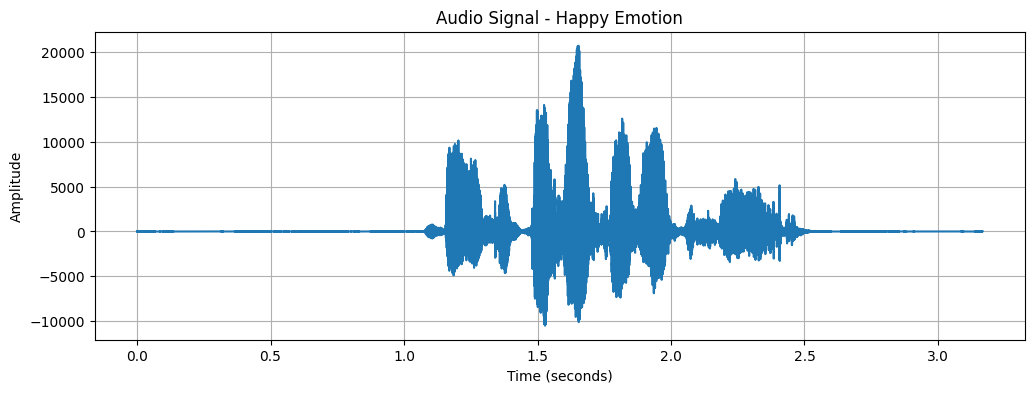

📊 Analyzing: 03-01-02-01-03-01-13.wav
Emotion: sad
Duration: 3.42 seconds
Sample rate: 48000 Hz
Signal length: 163932 samples
Signal statistics:
 Mean: -0.49
 Std: 531.96
 Min: -5595.00
 Max: 7317.00


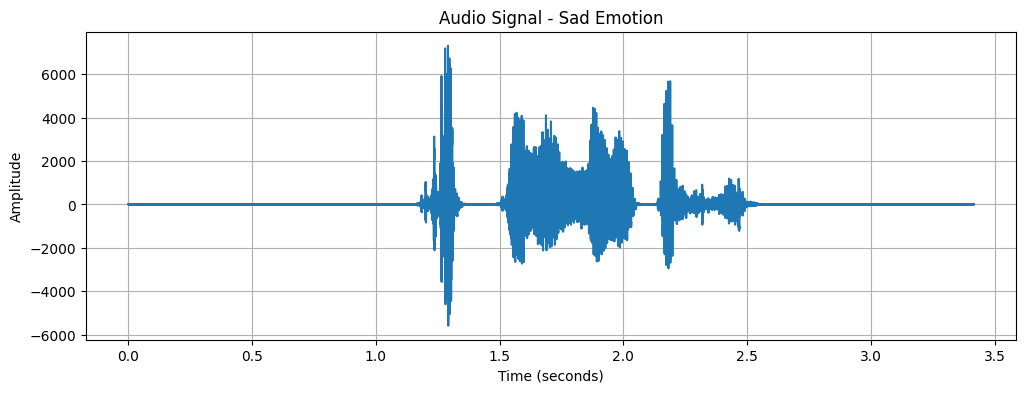


🔄 Extracting features...
 Processed 50/1080 files
 Processed 100/1080 files
 Processed 150/1080 files
 Processed 200/1080 files
 Processed 250/1080 files
 Processed 300/1080 files
 Processed 350/1080 files
 Processed 400/1080 files
 Processed 450/1080 files
 Processed 500/1080 files
 Processed 550/1080 files
 Processed 600/1080 files
 Processed 650/1080 files
 Processed 700/1080 files
 Processed 750/1080 files
 Processed 800/1080 files
 Processed 850/1080 files
 Processed 900/1080 files
 Processed 950/1080 files
 Processed 1000/1080 files
 Processed 1050/1080 files
 Processed 1080/1080 files

✅ Feature extraction complete! Extracted features from 1080 files
📊 Total features per file: 107
📊 Dataset shape: (1080, 107)
📊 Labels shape: (1080,)

📊 COMPARISON - Happy vs Sad:
Energy - Happy: 0.040482, Sad: 0.034033
ZCR - Happy: 0.280202, Sad: 0.517222
Centroid - Happy: 8906.56 Hz, Sad: 12798.06 Hz
MFCC 0 - Happy: -0.0000, Sad: -0.0000, Diff: 0.0000
MFCC 1 - Happy: 0.0000, Sad: -0.0000, Diff:

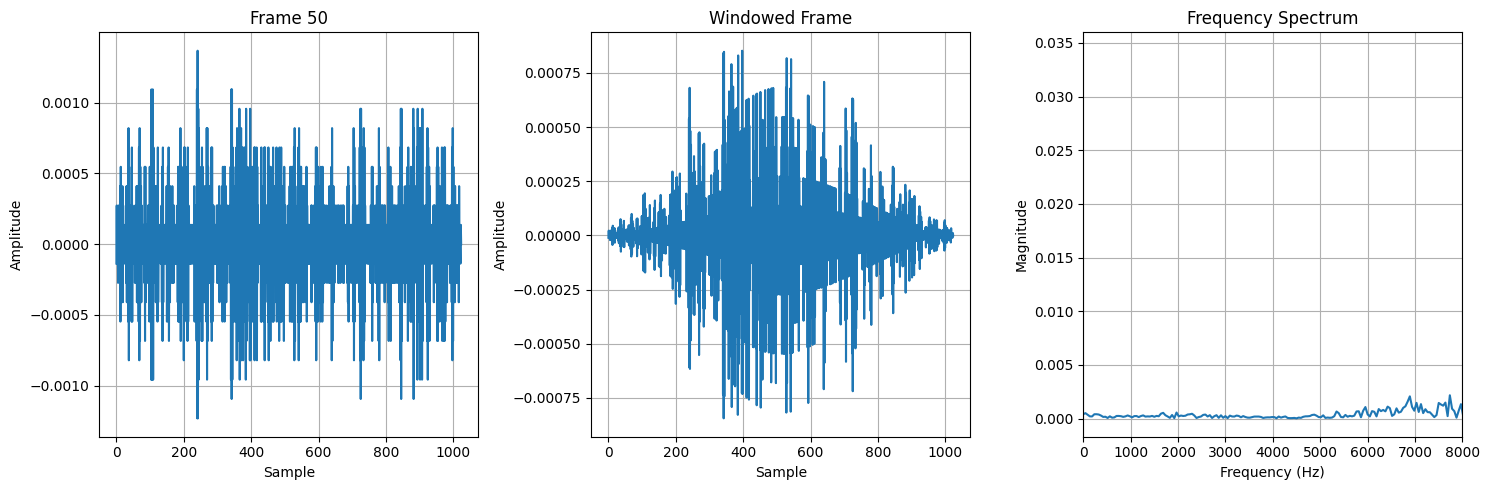

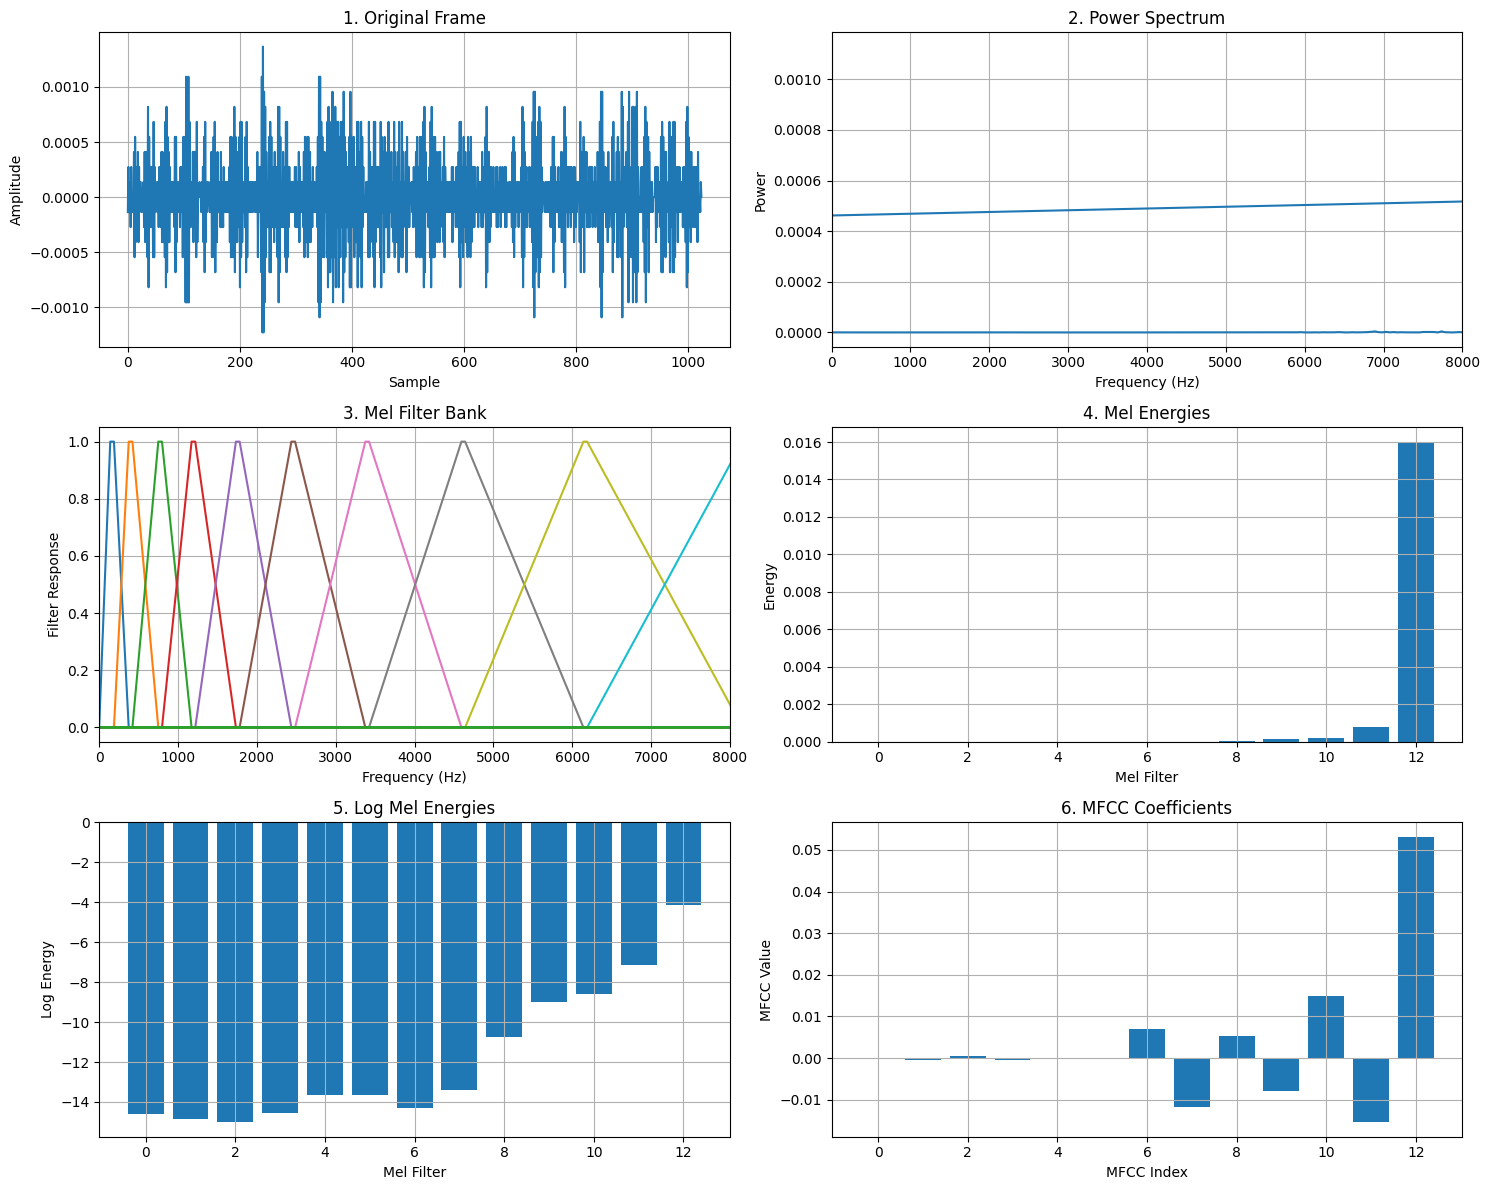


🔄 Splitting and scaling data...
📊 Feature scaling:
 Original - Mean: 411.9253, Std: 1981.4640
 Scaled - Mean: 0.0000, Std: 1.0000

🔍 Training and evaluating models...

📊 Training KNN...
📚 KNN trained with 864 samples, k=5
 Predicted 50/216 samples
 Predicted 100/216 samples
 Predicted 150/216 samples
 Predicted 200/216 samples
 Predicted 216/216 samples
🔍 KNN Accuracy: 0.6620

📊 Training Decision Tree...
📚 Decision Tree trained with 864 samples
 Predicted 50/216 samples
 Predicted 100/216 samples
 Predicted 150/216 samples
 Predicted 200/216 samples
 Predicted 216/216 samples
🔍 Decision Tree Accuracy: 0.5324

📊 Training Random Forest...
📚 Training Random Forest with 15 trees...
📚 Decision Tree trained with 864 samples
📚 Decision Tree trained with 864 samples
📚 Decision Tree trained with 864 samples
📚 Decision Tree trained with 864 samples
📚 Decision Tree trained with 864 samples
 Trained 5/15 trees
📚 Decision Tree trained with 864 samples
📚 Decision Tree trained with 864 samples
📚 Dec

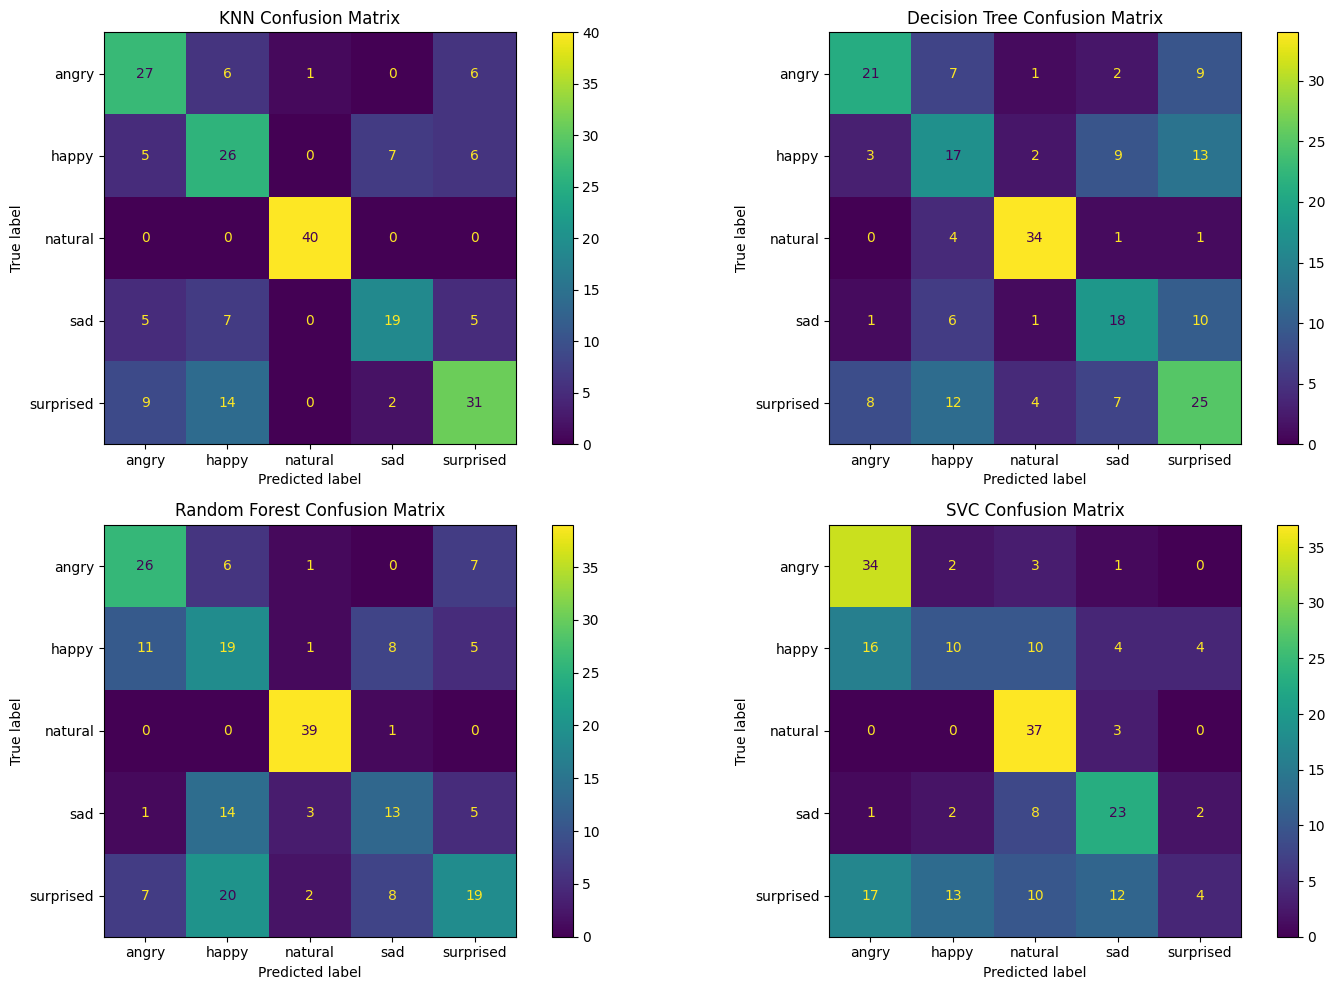


📊 Per-Class Metrics for Best KNN (k=1):

📊 Confusion Matrix (rows=actual, columns=predicted):
Actual\Predicted     angry     happy   natural       sad surprised
          angry        32         3         0         1         4
          happy         3        33         0         5         3
        natural         0         0        40         0         0
            sad         8         4         0        21         3
      surprised         5         5         0         3        43

ANGRY:
 Precision: 0.6667
 Recall: 0.8000
 F1-Score: 0.7273
 Support: 40 samples

HAPPY:
 Precision: 0.7333
 Recall: 0.7500
 F1-Score: 0.7416
 Support: 44 samples

NATURAL:
 Precision: 1.0000
 Recall: 1.0000
 F1-Score: 1.0000
 Support: 40 samples

SAD:
 Precision: 0.7000
 Recall: 0.5833
 F1-Score: 0.6364
 Support: 36 samples

SURPRISED:
 Precision: 0.8113
 Recall: 0.7679
 F1-Score: 0.7890
 Support: 56 samples

📊 Macro Averages:
 Macro Precision: 0.7823
 Macro Recall: 0.7802
 Macro F1-Score: 0.7788

📊 R

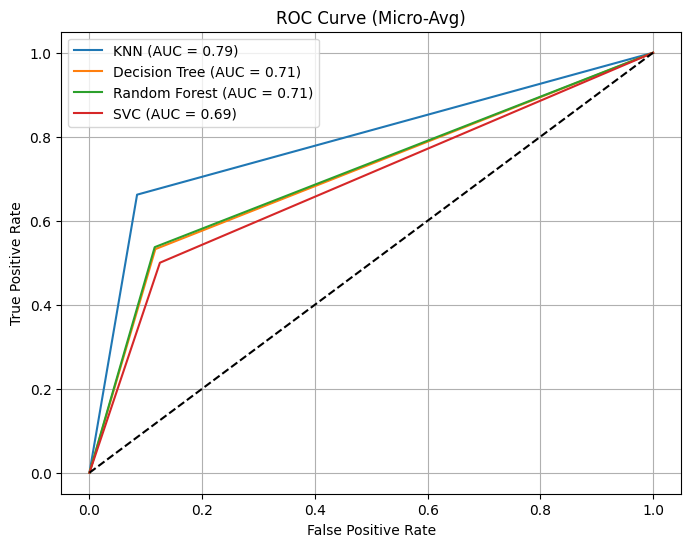


📊 SVC Loss Plot...
⚠️ No loss data available for plotting (insufficient iterations or empty losses).


<Figure size 640x480 with 0 Axes>


🔍 Model Insights:
📈 Decision Tree:
 - Interpretable: Clear decision rules
 - Fast prediction: Simple tree traversal
 - May overfit: Sensitive to training data

🌳 Random Forest:
 - Reduces overfitting: Multiple trees vote
 - Handles missing values well
 - Less interpretable than single tree

📏 SVM:
 - Good for high-dimensional data
 - Maximizes margin between classes
 - Sensitive to feature scaling

🔍 KNN:
 - Simple and intuitive
 - No training phase (lazy learning)
 - Can be slow for large datasets

✅ Analysis complete!


In [ ]:
if __name__ == "__main__":
    np.random.seed(42)
    print("🔍 Starting Emotion Recognition Pipeline...")

    zip_path = "/content/Dataset.zip"
    extract_path = extract_zip(zip_path)
    dataset_folder = None
    for root, dirs, _ in os.walk(extract_path):
        if any(d.lower() in ['angry', 'happy', 'sad', 'neutral', 'natural', 'surprised', 'panic'] for d in dirs):
            dataset_folder = root
            break
    if not dataset_folder:
        raise FileNotFoundError(" Could not find dataset folder structure")
    print(f"\n Found dataset at: {dataset_folder}")
    dataset_info = explore_dataset(dataset_folder)
    print("\n🔄 Loading audio files...")
    all_audio_data = load_audio_files(dataset_folder)
    print(f"\n📊 Dataset Summary:")
    print(f"Total files loaded: {len(all_audio_data)}")
    emotion_counts = {}
    total_duration = 0
    for data in all_audio_data:
        emotion = data['emotion']
        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
        total_duration += data['duration']
    print(f"Total duration: {total_duration:.2f} seconds")
    print("Files per emotion:")
    for emotion, count in emotion_counts.items():
        print(f" {emotion}: {count}")
    if all_audio_data:
        sample = all_audio_data[0]
        print(f"\n📋 Sample file info:")
        print(f" File: {sample['file_name']}")
        print(f" Emotion: {sample['emotion']}")
        print(f" Sample rate: {sample['sample_rate']} Hz")
        print(f" Duration: {sample['duration']:.2f} seconds")
        print(f" Signal shape: {sample['signal'].shape}")

    # Analyze sample audio for happy and sad emotions
    print("\n🔍 Analyzing sample audio files...")
    happy_signal, happy_sr = analyze_sample_audio(all_audio_data, emotion='happy', file_index=0)
    sad_signal, sad_sr = analyze_sample_audio(all_audio_data, emotion='sad', file_index=0)

    print("\n🔄 Extracting features...")
    all_features = []
    labels = []
    for i, audio_data in enumerate(all_audio_data):
        try:
            features = extract_all_features(audio_data['signal'], audio_data['sample_rate'])
            features['emotion'] = audio_data['emotion']
            all_features.append(features)
            labels.append(audio_data['emotion'])
            if (i + 1) % 50 == 0 or i == len(all_audio_data) - 1:
                print(f" Processed {i + 1}/{len(all_audio_data)} files")
        except Exception as e:
            print(f" Error processing {audio_data['file_name']}: {e}")
    print(f"\n Feature extraction complete! Extracted features from {len(all_features)} files")
    feature_names = [key for key in all_features[0].keys() if key != 'emotion']
    print(f" Total features per file: {len(feature_names)}")
    X = np.zeros((len(all_features), len(feature_names)))
    y = np.array(labels)
    for i, features in enumerate(all_features):
        for j, feature_name in enumerate(feature_names):
            X[i, j] = features[feature_name]
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    print(f" Dataset shape: {X.shape}")
    print(f" Labels shape: {y.shape}")

    # Compare happy vs sad features
    happy_features = [f for f in all_features if f['emotion'] == 'happy'][0]
    sad_features = [f for f in all_features if f['emotion'] == 'sad'][0]
    print("\n COMPARISON - Happy vs Sad:")
    print(f"Energy - Happy: {happy_features['energy_mean']:.6f}, Sad: {sad_features['energy_mean']:.6f}")
    print(f"ZCR - Happy: {happy_features['zcr_mean']:.6f}, Sad: {sad_features['zcr_mean']:.6f}")
    print(f"Centroid - Happy: {happy_features['spectral_centroid_mean']:.2f} Hz, Sad: {sad_features['spectral_centroid_mean']:.2f} Hz")
    for i in range(5):
        happy_mean = happy_features[f'mfcc_{i}_mean']
        sad_mean = sad_features[f'mfcc_{i}_mean']
        print(f"MFCC {i} - Happy: {happy_mean:.4f}, Sad: {sad_mean:.4f}, Diff: {happy_mean-sad_mean:.4f}")

    print("\n📊 Visualizing sample features...")
    sample_frames = create_frames(preprocess_audio(all_audio_data[0]['signal']))
    visualize_features(sample_frames, all_audio_data[0]['sample_rate'])
    visualize_mfcc_process(sample_frames)

    print("\n🔄 Splitting and scaling data...")
    label_to_index, index_to_label = create_label_encoder(y)
    y_encoded = np.array([label_to_index[label] for label in y])
    X_train, X_test, y_train, y_test = manual_train_test_split(X, y_encoded)
    X_train_scaled, X_test_scaled, scaler_mean, scaler_std = manual_standard_scaler(X_train, X_test)

    print("\n🔍 Training and evaluating models...")
    results = {}
    models = {
        'KNN': ManualKNN(k=5),
        'Decision Tree': ManualDecisionTree(max_depth=8, min_samples_split=5),
        'Random Forest': ManualRandomForest(n_trees=15, max_depth=8, min_samples_split=5),
        'SVC': ManualSVC(C=1.0, max_iter=2000, learning_rate=0.001)
    }
    for name, model in models.items():
        print(f"\n Training {name}...")
        if name == 'SVC':
            model.fit(X_train_scaled, y_train, random_state=42)
        else:
            model.fit(X_train_scaled, y_train)
        y_pred_encoded = model.predict(X_test_scaled)
        y_pred = np.array([index_to_label[idx] for idx in y_pred_encoded])
        results[name] = y_pred
        y_test_str = np.array([index_to_label[idx] for idx in y_test])
        acc = np.mean(y_pred == y_test_str)
        print(f"🔍 {name} Accuracy: {acc:.4f}")

    print("\n KNN Hyperparameter Tuning...")
    knn_results = {}
    for k in [1, 3, 5, 7, 9]:
        knn = ManualKNN(k=k)
        knn.fit(X_train_scaled, y_train)
        y_pred_encoded = knn.predict(X_test_scaled)
        y_pred = np.array([index_to_label[idx] for idx in y_pred_encoded])
        y_test_str = np.array([index_to_label[idx] for idx in y_test])
        acc = np.mean(y_pred == y_test_str)
        knn_results[k] = {'accuracy': acc, 'predictions': y_pred}
        print(f" KNN (k={k}) Accuracy: {acc:.4f}")
    best_k = max(knn_results.keys(), key=lambda k: knn_results[k]['accuracy'])
    print(f" Best k: {best_k} with accuracy: {knn_results[best_k]['accuracy']:.4f}")

    print("\n Detailed Evaluation...")
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    for i, (name, y_pred) in enumerate(results.items()):
        y_test_str = np.array([index_to_label[idx] for idx in y_test])
        cm, classes = create_confusion_matrix(y_test_str, y_pred, list(set(y_test_str)))
        ax = axs[i//2][i%2]
        ConfusionMatrixDisplay(cm, display_labels=classes).plot(ax=ax, values_format='d')
        ax.set_title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("\n Per-Class Metrics for Best KNN (k=1):")
    y_test_str = np.array([index_to_label[idx] for idx in y_test])
    conf_matrix, classes = create_confusion_matrix(y_test_str, knn_results[1]['predictions'], list(set(y_test_str)))
    print_confusion_matrix(conf_matrix, classes)
    metrics = calculate_metrics(conf_matrix, classes)
    for class_name, metric in metrics.items():
        print(f"\n{class_name.upper()}:")
        print(f" Precision: {metric['precision']:.4f}")
        print(f" Recall: {metric['recall']:.4f}")
        print(f" F1-Score: {metric['f1_score']:.4f}")
        print(f" Support: {metric['support']} samples")
    macro_precision = np.mean([m['precision'] for m in metrics.values()])
    macro_recall = np.mean([m['recall'] for m in metrics.values()])
    macro_f1 = np.mean([m['f1_score'] for m in metrics.values()])
    print(f"\n Macro Averages:")
    print(f" Macro Precision: {macro_precision:.4f}")
    print(f" Macro Recall: {macro_recall:.4f}")
    print(f" Macro F1-Score: {macro_f1:.4f}")

    print("\n ROC Curves...")
    plt.figure(figsize=(8, 6))
    y_test_str = np.array([index_to_label[idx] for idx in y_test])
    y_bin = label_binarize(y_test_str, classes=classes)
    for name, y_pred in results.items():
        y_score = label_binarize(y_pred, classes=classes)
        fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score.ravel())
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Micro-Avg)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n SVC Loss Plot...")
    plt.figure()
    if models['SVC'].losses:
        plt.plot(models['SVC'].losses, marker='o')
        plt.title('SVC Loss vs Epochs')
        plt.xlabel('Epoch (every 200 iterations)')
        plt.ylabel('Loss')
        plt.grid(True)
    else:
        print(" No loss data available for plotting (insufficient iterations or empty losses).")
    plt.show()

    print("\n  Model Insights:")
    print("  Decision Tree:")
    print(" - Interpretable: Clear decision rules")
    print(" - Fast prediction: Simple tree traversal")
    print(" - May overfit: Sensitive to training data")
    print("\n Random Forest:")
    print(" - Reduces overfitting: Multiple trees vote")
    print(" - Handles missing values well")
    print(" - Less interpretable than single tree")
    print("\n SVM:")
    print(" - Good for high-dimensional data")
    print(" - Maximizes margin between classes")
    print(" - Sensitive to feature scaling")
    print("\n KNN:")
    print(" - Simple and intuitive")
    print(" - No training phase (lazy learning)")
    print(" - Can be slow for large datasets")
    print("\n Analysis complete!")